In [1]:
from src.models.vit_continuous_module import ViTContinuousLitModule
from src.models.components.tokenized_vit_continuous import TokenizedViTContinuous

/mnt/miniconda3/envs/climate_pretrain/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/mnt/miniconda3/envs/climate_pretrain/lib/python3.8/site-packages/pytorch_lightning/utilities/cli.py:95: LightningDeprecationWarning: `LightningCLI`'s registries were deprecated in v1.7 and will be removed in v1.9. Now any imported subclass is automatically available by name in `LightningCLI` without any need to explicitly register it.
  rank_zero_deprecation(_deprecate_registry_message)


In [89]:
net_args = {
    'climate_modeling': False,
    'time_history': 1,
    'img_size': [128,256],
    'patch_size': 4,
    'default_vars': [
      "land_sea_mask",
      "orography",
      "lattitude",
      "2m_temperature",
      "10m_u_component_of_wind",
      "10m_v_component_of_wind",
      # "toa_incident_solar_radiation",
      # 'total_precipitation',
      "geopotential_50",
      "geopotential_250",
      "geopotential_500",
      "geopotential_600",
      "geopotential_700",
      "geopotential_850",
      "geopotential_925",
      "u_component_of_wind_50",
      "u_component_of_wind_250",
      "u_component_of_wind_500",
      "u_component_of_wind_600",
      "u_component_of_wind_700",
      "u_component_of_wind_850",
      "u_component_of_wind_925",
      "v_component_of_wind_50",
      "v_component_of_wind_250",
      "v_component_of_wind_500",
      "v_component_of_wind_600",
      "v_component_of_wind_700",
      "v_component_of_wind_850",
      "v_component_of_wind_925",
      "temperature_50",
      "temperature_250",
      "temperature_500",
      "temperature_600",
      "temperature_700",
      "temperature_850",
      "temperature_925",
      "relative_humidity_50",
      "relative_humidity_250",
      "relative_humidity_500",
      "relative_humidity_600",
      "relative_humidity_700",
      "relative_humidity_850",
      "relative_humidity_925",
      "specific_humidity_50",
      "specific_humidity_250",
      "specific_humidity_500",
      "specific_humidity_600",
      "specific_humidity_700",
      "specific_humidity_850",
      "specific_humidity_925",
    ],
    'out_vars': ["v10"],
    'channel_agg': "attention",
    'embed_dim': 1024,
    'depth': 8,
    'decoder_depth': 2,
    'num_heads': 16,
    'mlp_ratio': 4.0,
    'init_mode': "small",
}

net = TokenizedViTContinuous(**net_args)

In [90]:
model = ViTContinuousLitModule(
    net = net,
    pretrained_path = '/datadrive/datasets/checkpoints/finetuned/1.40625deg/mpi_tai_awi_hammoz_cmcc/1024dim/v10/7days/best.ckpt'
)

Loading pre-trained checkpoint from: /datadrive/datasets/checkpoints/finetuned/1.40625deg/mpi_tai_awi_hammoz_cmcc/1024dim/v10/7days/best.ckpt
<All keys matched successfully>


In [91]:
from src.datamodules.finetune_module import ERA5IterDatasetContinuousModule

In [92]:
datamodule = ERA5IterDatasetContinuousModule(
    root_dir='/datadrive/datasets/era5_forecast_1.40625deg_7days/',
    variables=[
      "lsm",
      "orography",
      "lat2d",
      "t2m",
      "u10",
      "v10",
      # "tisr",
      # 'tp',
      "z_50",
      "z_250",
      "z_500",
      "z_600",
      "z_700",
      "z_850",
      "z_925",
      "u_50",
      "u_250",
      "u_500",
      "u_600",
      "u_700",
      "u_850",
      "u_925",
      "v_50",
      "v_250",
      "v_500",
      "v_600",
      "v_700",
      "v_850",
      "v_925",
      "t_50",
      "t_250",
      "t_500",
      "t_600",
      "t_700",
      "t_850",
      "t_925",
      "r_50",
      "r_250",
      "r_500",
      "r_600",
      "r_700",
      "r_850",
      "r_925",
      "q_50",
      "q_250",
      "q_500",
      "q_600",
      "q_700",
      "q_850",
      "q_925",
    ],
    out_variables=["v10"],
    region='Global',
    predict_range=168,
    hrs_each_step=1,
    buffer_size=2000,
    batch_size=1
)

In [93]:
datamodule.set_patch_size(model.get_patch_size())

normalization = datamodule.output_transforms
mean_norm, std_norm = normalization.mean, normalization.std
mean_denorm, std_denorm = -mean_norm / std_norm, 1 / std_norm
model.set_denormalization(mean_denorm, std_denorm)
model.set_lat_lon(*datamodule.get_lat_lon())
model.set_pred_range(datamodule.hparams.predict_range)
model.set_val_clim(datamodule.val_clim)
model.set_test_clim(datamodule.test_clim)

In [94]:
datamodule.setup()

In [95]:
import os
import random
import numpy as np
import torch
import matplotlib.pyplot as plt
from datetime import datetime

def visualize_forecast(model_module, data_module, pred_task, var_name, save_path = None):
    model_module.eval()
    model_module.cuda()

    dataloader = data_module.test_dataloader()
    x, y, lead_times, in_vars, out_vars, region_info = next(iter(dataloader))
    x = x.cuda()
    y = y.cuda()
    lead_times = lead_times.cuda()

    fig, axes = plt.subplots(1, 4, figsize=(30, 3), squeeze = False)
    
    with torch.no_grad():
        _, pred = model_module.net.forward(x, y, lead_times, in_vars, out_vars, region_info, None, model_module.lat)
    
    var_id = model_module.net.get_channel_ids(out_vars)
    x = x[:, :, var_id]

    inv_normalize = model_module.denormalization
    init_condition, gt = inv_normalize(x), inv_normalize(y)
    pred = inv_normalize(pred)
    bias = pred - gt
    
    index = 0

    for i, tensor in enumerate([init_condition, gt, pred, bias]):
        ax = axes[index][i]
        im = ax.imshow(tensor.detach().squeeze().cpu().numpy())
        im.set_cmap(cmap=plt.cm.RdBu)
        fig.colorbar(im, ax=ax)

    axes[index][0].set_title(f"Initial condition [{var_name}]")
    axes[index][1].set_title(f"Ground truth [{var_name}]")
    axes[index][2].set_title(f"{pred_task} Prediction [{var_name}]")
    axes[index][3].set_title(f"Bias [{var_name}]")

    fig.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path)
    else:
        plt.show()
        
    del x
    del y
    del pred

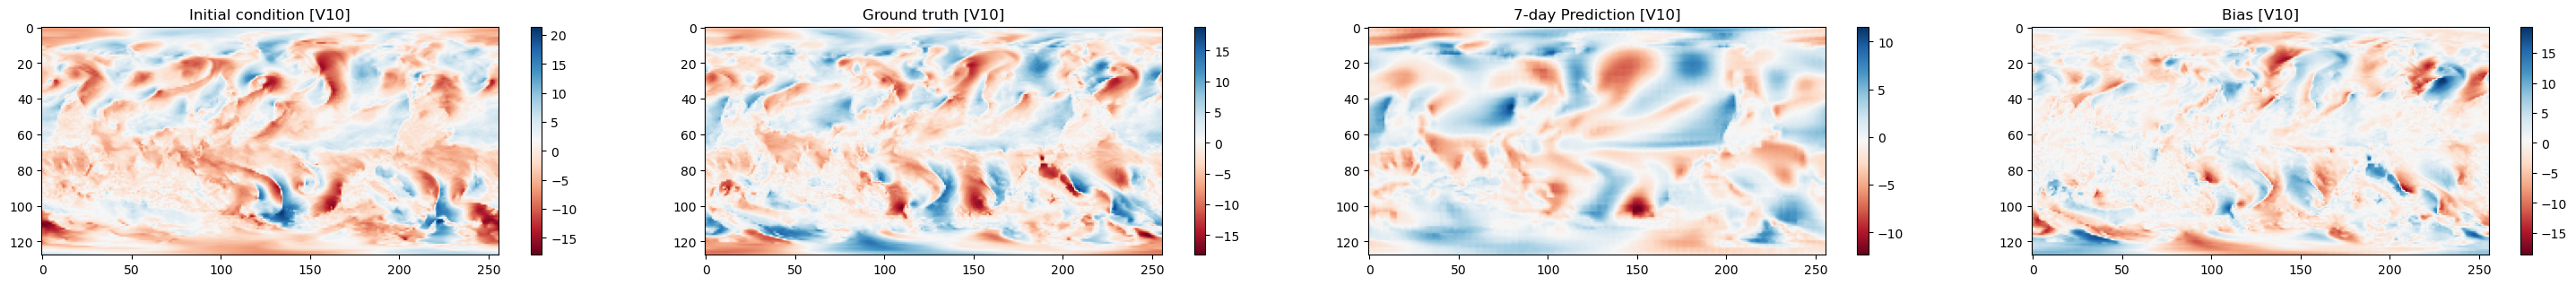

In [96]:
visualize_forecast(model, datamodule, '7-day', 'V10', 'forecast_v10_7days.png')